# Info

https://www.kaggle.com/datasets/balraj98/edges2shoes-dataset

In [93]:
# import shutil
# import os

# output_dir = '/kaggle/working'

# for filename in os.listdir(output_dir):
#     file_path = os.path.join(output_dir, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print(f'Failed to delete {file_path}. Reason: {e}')

# print('All files in /kaggle/working have been deleted.')


# Libraries Import

In [94]:
import glob
import cv2
import tqdm

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
import kagglehub

In [97]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [98]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras.applications import ResNet50

In [99]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [100]:
from concurrent.futures import ThreadPoolExecutor

# Constants

In [101]:
IMG_W = 256
IMG_H = 256

BATCH_SIZE = 46

VAL_SPLIT = 0.3

BASE_DIR = r'/kaggle/working/'
# BASE_DIR = ''

# Functions

In [102]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset

In [103]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("balraj98/edges2shoes-dataset")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/edges2shoes-dataset


# Dataset Read

In [104]:
def walk_inside_folder(folder_path):
  EXTENSIONS = ['png', 'jpeg', 'jpg']

  images_paths = []
    
  for root,dirs,files in tqdm.tqdm(os.walk(folder_path)):
    for ext in EXTENSIONS:
      images_paths = images_paths + glob.glob(os.path.join(root,'*.'+ext))
        
  return images_paths


In [105]:
images_paths = walk_inside_folder(dataset_path)

3it [00:00, 10.51it/s]


# Exploration & Visualization

In [106]:
print(f"Total images: {len(images_paths)}")

Total images: 50025


In [107]:
np.random.shuffle(images_paths)
images_paths = images_paths[0:15_000]

In [108]:
for i in range(13):
    print(f"Image[{i:02d}] Shape:", cv2.imread(images_paths[i]).shape)

Image[00] Shape: (256, 512, 3)
Image[01] Shape: (256, 512, 3)
Image[02] Shape: (256, 512, 3)
Image[03] Shape: (256, 512, 3)
Image[04] Shape: (256, 512, 3)
Image[05] Shape: (256, 512, 3)
Image[06] Shape: (256, 512, 3)
Image[07] Shape: (256, 512, 3)
Image[08] Shape: (256, 512, 3)
Image[09] Shape: (256, 512, 3)
Image[10] Shape: (256, 512, 3)
Image[11] Shape: (256, 512, 3)
Image[12] Shape: (256, 512, 3)


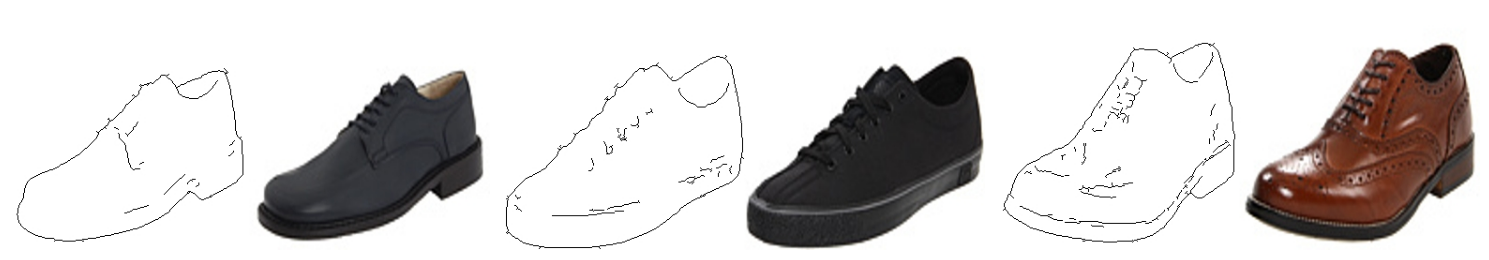

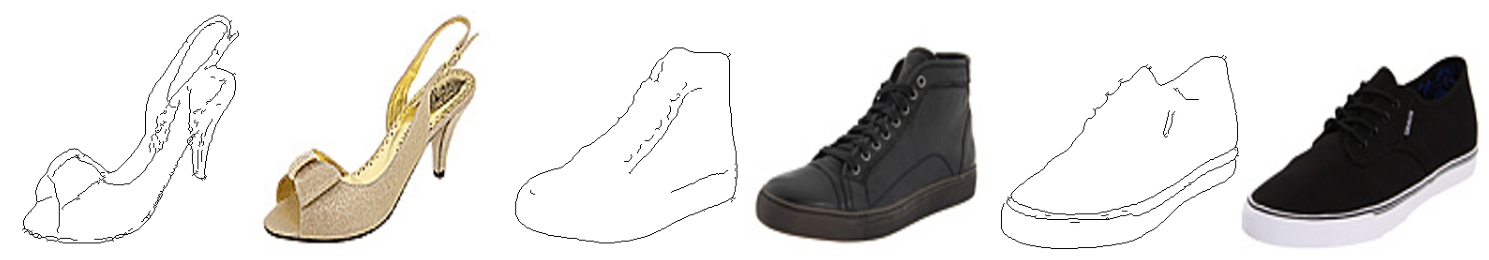

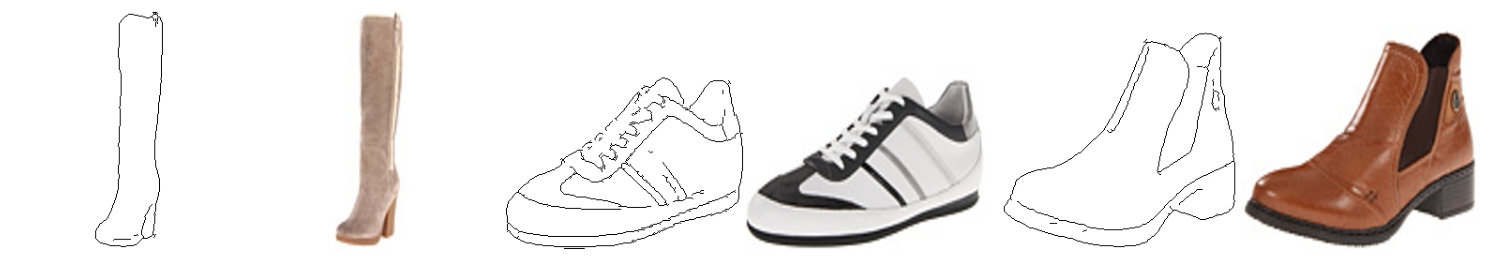

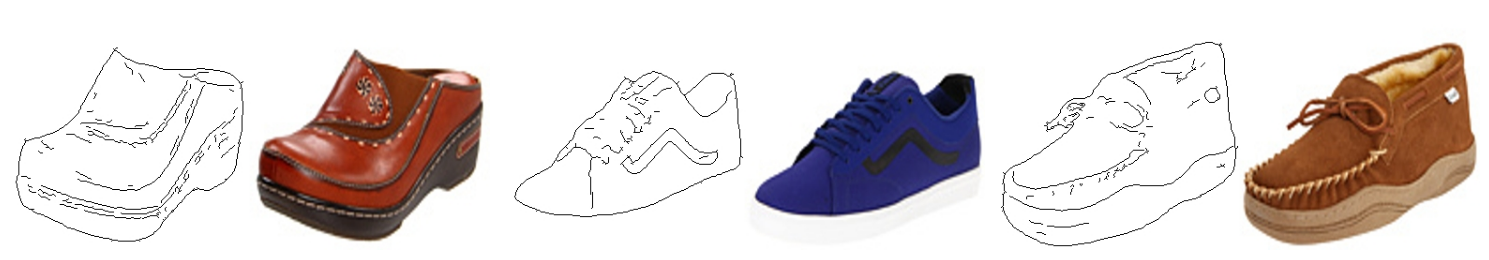

In [109]:
N_ROWS = 4
N_COLS = 3

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(15, 15))

    for j in range(N_COLS):
            id_j = np.random.randint(0, len(images_paths))
            img_path_i = images_paths[id_j]
            img_i = cv2.imread(img_path_i, 1)
            img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)

            axs[j].imshow(img_i, cmap='gray')
            axs[j].axis('off')

    fig.tight_layout()
    plt.show()

# Images Preprocessing

Blur Filters

In [110]:
# make image smooth
def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# remove salt and pepper noise
def apply_filter_median(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# preserve edges while reducing noise
def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

Edge Detection

In [111]:
def apply_canny(image, threshold1=20, threshold2=110):
    return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

In [112]:
def preprocess_image_from_path(image_path, edge_type=0):
    image = cv2.imread(image_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (2 * IMG_W, IMG_H))

    edge_img = image[:, 0:IMG_H]
    shoes_img = image[:, IMG_H:]

    shoes_img = apply_filter_median(shoes_img)

    edge_img = cv2.cvtColor(edge_img, cv2.COLOR_RGB2GRAY)
    edge_img = np.expand_dims(edge_img, axis=-1)

    shoes_img_grey_img = cv2.cvtColor(shoes_img, cv2.COLOR_RGB2GRAY)
    canny_edges = apply_canny(shoes_img_grey_img)

    shoes_img = (shoes_img / 255.0).astype(np.float32)
    edge_img = (edge_img / 255.0).astype(np.float32)
    canny_edges = (canny_edges / 255.0).astype(np.float32)

    canny_edges = 1 - canny_edges  # swap black and white

    shoes_img = cv2.resize(shoes_img, (IMG_W, IMG_H))
    edge_img = cv2.resize(edge_img, (IMG_W, IMG_H))
    canny_edges = cv2.resize(canny_edges, (IMG_W, IMG_H))

    if len(edge_img.shape) == 2:
        edge_img = np.expand_dims(edge_img, axis=-1)

    if len(canny_edges.shape) == 2:
        canny_edges = np.expand_dims(canny_edges, axis=-1)

    # Create a noise channel of the same size as edge_img
    noise_channel = np.random.uniform(-1, 1, size=edge_img.shape).astype(np.float32)

    # Concatenate edge and noise to make a 2-channel input
    edge_img = np.concatenate([edge_img, noise_channel], axis=-1)
    canny_edges = np.concatenate([canny_edges, noise_channel], axis=-1)

    shoes_img = shoes_img * 2 - 1
    canny_edges = canny_edges * 2 - 1
    # edge_img is already scaled to [-1, 1] because noise is [-1, 1] and edge was scaled before

    return [shoes_img, edge_img, canny_edges]


(256, 256, 3) (256, 256, 2) (256, 256, 2) 1.0 -0.6862745 1.0 -0.99998146 1.0 -2.9999628


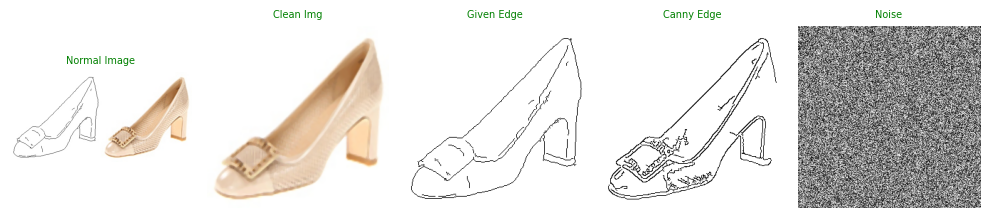

(256, 256, 3) (256, 256, 2) (256, 256, 2) 1.0 -0.94509804 1.0 -0.99999505 1.0 -2.99999


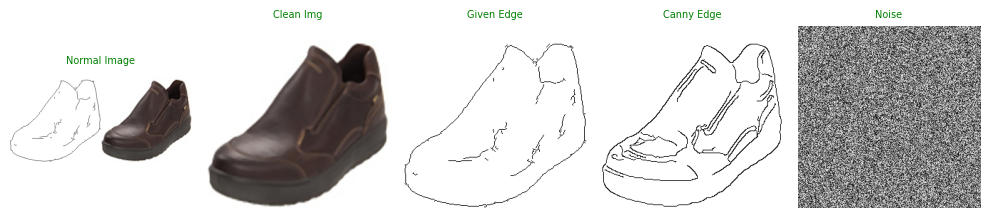

(256, 256, 3) (256, 256, 2) (256, 256, 2) 1.0 -0.92941177 1.0 -0.99994755 1.0 -2.999895


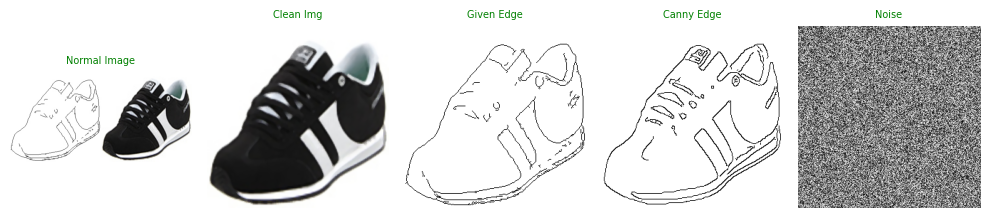

(256, 256, 3) (256, 256, 2) (256, 256, 2) 1.0 -0.90588236 1.0 -0.9999939 1.0 -2.9999878


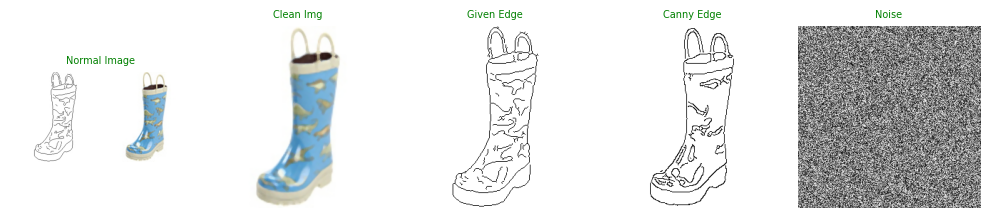

(256, 256, 3) (256, 256, 2) (256, 256, 2) 1.0 -0.7411765 1.0 -0.9999428 1.0 -2.9998856


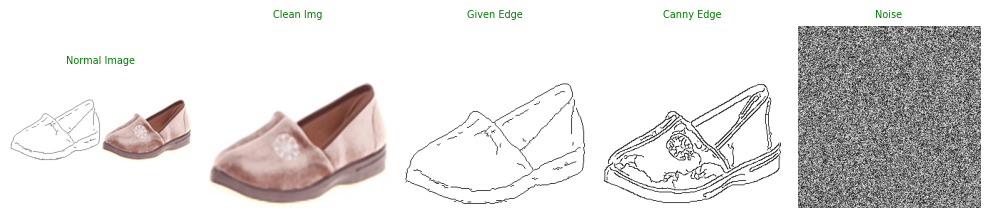

In [113]:
N_ROWS = 5
IMG_SHAPE = None

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, 5, figsize=(10, 4))
    id_j = np.random.randint(0, len(images_paths))
    img_path_i = images_paths[id_j]

    img_i = cv2.imread(img_path_i, 1)
    img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)
    img_i_processed, edge_img, canny_img = preprocess_image_from_path(img_path_i)

    print(img_i_processed.shape, edge_img.shape,  canny_img.shape ,np.max(img_i_processed), np.min(img_i_processed), np.max(edge_img), np.min(edge_img), np.max(canny_img), np.min(canny_img))

    axs[0].imshow(img_i.squeeze())
    axs[0].set_title(f"Normal Image", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(img_i_processed * 0.5 + 0.5)
    axs[1].set_title(f"Clean Img", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(edge_img[:,:,0] * 0.5 + 0.5, cmap='gray')
    axs[2].set_title(f"Given Edge", fontsize=7, color='green')
    axs[2].axis('off')

    axs[3].imshow(canny_img[:,:,0] * 0.5 + 0.5, cmap='gray')
    axs[3].set_title(f"Canny Edge", fontsize=7, color='green')
    axs[3].axis('off')

    axs[4].imshow(canny_img[:,:,1] * 0.5 + 0.5, cmap='gray')
    axs[4].set_title(f"Noise", fontsize=7, color='green')
    axs[4].axis('off')
    
    IMG_SHAPE = img_i_processed.shape

    fig.tight_layout()
    plt.show()

# Data Split

In [114]:
threshold = VAL_SPLIT * len(images_paths)

np.random.shuffle(images_paths)
images_paths_train = images_paths[:-int(threshold)]
images_paths_val = images_paths[-int(threshold):]

In [115]:
print(f"Train images: {len(images_paths_train)}")
print(f"Val images: {len(images_paths_val)}")

Train images: 10500
Val images: 4500


# Data Augmentation

In [116]:
def custom_augmentation_numpy(image, edge_img):
    # -----------------------------
    # 1. Random Horizontal Flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        edge_img = np.fliplr(edge_img)

    # -----------------------------
    # 2. Random Vertical Flip
    # if np.random.rand() > 0.5:
    #     image = np.flipud(image)
    #     edge_img = np.flipud(edge_img)

    # -----------------------------
    # 3. Random Rotation (-15 to 15 degrees)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-15, 15)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)
        edge_img = cv2.warpAffine(edge_img, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)

    # -----------------------------
    # 4. Random Crop and Resize Back
    if np.random.rand() > 0.5:
        h, w = image.shape[:2]
        crop_scale = np.random.uniform(0.9, 1.0)
        new_h, new_w = int(h * crop_scale), int(w * crop_scale)
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)
        image = image[top:top + new_h, left:left + new_w]
        edge_img = edge_img[top:top + new_h, left:left + new_w]
        image = cv2.resize(image, (w, h))
        edge_img = cv2.resize(edge_img, (w, h), interpolation=cv2.INTER_NEAREST)

    # -----------------------------
    # 5. Random Brightness (image only)
    if np.random.rand() > 0.5:
        brightness_shift = np.random.uniform(-0.05, 0.05)
        image = image + brightness_shift
        image = np.clip(image, -1, 1)

    # -----------------------------
    # 6. Random Contrast (image only)
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = (image - mean) * factor + mean
        image = np.clip(image, -1, 1)

    # -----------------------------
    # 7. Random Gaussian Noise (image only)
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.025, image.shape)
        image = image + noise
        image = np.clip(image, -1, 1)

    # Ensure edge_img has channel dimension
    if len(edge_img.shape) == 2:
        edge_img = np.expand_dims(edge_img, axis=-1)

    # -----------------------------
    # No need to rescale anymore

    return image, edge_img


In [117]:
from collections import OrderedDict
from tensorflow.keras.utils import Sequence
import numpy as np
from concurrent.futures import ThreadPoolExecutor

class MyDataGenerator(Sequence):
    _shared_image_cache = OrderedDict()
    _max_cache_size = 15_000  # default cache limit

    def __init__(self, images_paths, batch_size=32, augment=True, shuffle=True, n_workers=4, max_cache_size=None):
        self.images_paths = np.array(images_paths)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers
        self.on_epoch_end()

        if max_cache_size is not None:
            MyDataGenerator._max_cache_size = max_cache_size

    def __len__(self):
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images_paths = self.images_paths[batch_x]
        batch_images_edge_pairs = self._load_images_parallel(batch_images_paths)

        if self.augment:
            batch_images_edge_pairs = [custom_augmentation_numpy(*img) for img in batch_images_edge_pairs]

        return np.array([x[1] for x in batch_images_edge_pairs]), np.array([x[0] for x in batch_images_edge_pairs])

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_images_parallel(self, paths):
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            image_edge_pairs = list(executor.map(self._load_and_preprocess_single, paths))
        return image_edge_pairs

    def _load_and_preprocess_single(self, path):
        cache = MyDataGenerator._shared_image_cache
        if path in cache:
            selected_pair = cache[path]
        else:
            image_edge_pair = preprocess_image_from_path(path)
            # Only cache if under limit
            if len(cache) < MyDataGenerator._max_cache_size:
                cache[path] = image_edge_pair
            selected_pair = image_edge_pair

        img, given_edge, canny_edge = selected_pair
        return img, [given_edge, canny_edge][int(np.random.rand() > 0.5)]

    @classmethod
    def clear_cache(cls):
        cls._shared_image_cache.clear()


In [118]:
train_generator = MyDataGenerator(images_paths_train, batch_size=BATCH_SIZE, augment=True, shuffle=True)

train_pure_generator = MyDataGenerator(images_paths_train, batch_size=BATCH_SIZE, augment=False, shuffle=False)
val_generator = MyDataGenerator(images_paths_val, batch_size=BATCH_SIZE, augment=False, shuffle=False)

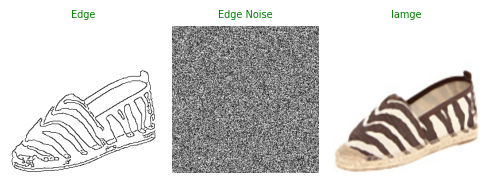

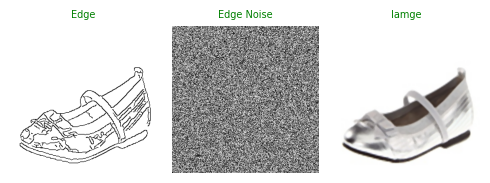

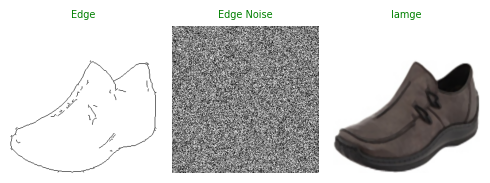

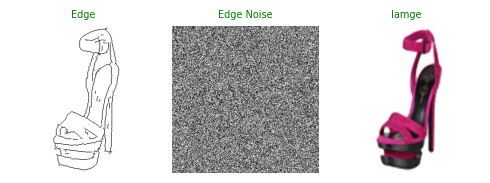

In [119]:
random_batch_x,random_batch_y  = val_generator[0]

for i in range(4):
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i][:,:,0] * 0.5 + 0.5, cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_x[i][:,:,1] * 0.5 + 0.5, cmap='gray')
    axs[1].set_title(f"Edge Noise", fontsize=7, color='green')
    axs[1].axis('off')
    
    axs[2].imshow(random_batch_y[i]  * 0.5 + 0.5, cmap='gray')
    axs[2].set_title(f"Iamge", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.show()

# Model Encapsulation

In [138]:
# import os

# file_path = '/kaggle/working/gan_deep_v1_discrim.weights.h5'

# if os.path.exists(file_path):
#     os.remove(file_path)
#     print(f"Deleted: {file_path}")
# else:
#     print(f"File not found: {file_path}")


In [139]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR)
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [140]:
class CustomModel:
    def __init__(self, name, gen_model, discrim_model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.gen_model = gen_model
        self.discrim_model = discrim_model
        self.trained = False

        # IMPROVED: Different learning rates for better stability
        self.gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
        self.disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

        # Enhanced loss tracking
        self.loss_history = {
            "discriminator": [],
            "generator": [],
            "l1": [],
            "ssim": [],
            "color": [],
            "perceptual": []
        }

        self.load()

    def l1_loss(self, y_true, y_pred):
        """L1 loss for pixel-wise accuracy"""
        return tf.reduce_mean(tf.abs(y_true - y_pred))

    def ssim_loss(self, y_true, y_pred):
        """Structural Similarity loss"""
        return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=2.0))
    
    def color_preservation_loss(self, y_true, y_pred):
        """NEW: Prevents color saturation and brown/burnt artifacts"""
        # Convert from [-1,1] to [0,1] for HSV conversion
        y_true_rgb = tf.clip_by_value((y_true + 1) / 2, 0.0, 1.0)
        y_pred_rgb = tf.clip_by_value((y_pred + 1) / 2, 0.0, 1.0)
        
        # Convert to HSV for better color control
        y_true_hsv = tf.image.rgb_to_hsv(y_true_rgb)
        y_pred_hsv = tf.image.rgb_to_hsv(y_pred_rgb)
        
        # Hue loss - prevents color shifting (most important for natural colors)
        hue_diff = tf.abs(y_true_hsv[..., 0] - y_pred_hsv[..., 0])
        # Handle hue wraparound (0 and 1 are the same hue)
        hue_diff = tf.minimum(hue_diff, 1.0 - hue_diff)
        hue_loss = tf.reduce_mean(hue_diff)
        
        # Saturation control - prevents over-saturation (brown/burnt look)
        sat_true = y_true_hsv[..., 1]
        sat_pred = y_pred_hsv[..., 1]
        
        # Penalize excessive saturation that causes burnt appearance
        over_sat_penalty = tf.reduce_mean(tf.nn.relu(sat_pred - 0.75) ** 2)
        
        # Normal saturation loss
        sat_loss = tf.reduce_mean(tf.abs(sat_true - sat_pred))
        
        # Value (brightness) should be preserved
        val_loss = tf.reduce_mean(tf.abs(y_true_hsv[..., 2] - y_pred_hsv[..., 2]))
        
        return hue_loss * 2.0 + sat_loss + over_sat_penalty * 3.0 + val_loss

    def perceptual_loss(self, y_true, y_pred):
        """NEW: Perceptual loss for better visual quality"""
        # Channel-wise statistics
        def channel_stats(x):
            mean = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
            var = tf.reduce_mean((x - mean) ** 2, axis=[1, 2])
            return mean, var
        
        true_mean, true_var = channel_stats(y_true)
        pred_mean, pred_var = channel_stats(y_pred)
        
        mean_loss = tf.reduce_mean(tf.abs(true_mean - pred_mean))
        var_loss = tf.reduce_mean(tf.abs(true_var - pred_var))
        
        return mean_loss + var_loss * 0.5

    def gradient_penalty(self, real_samples, fake_samples):
        """Gradient penalty for training stability"""
        alpha = tf.random.uniform([tf.shape(real_samples)[0], 1, 1, 1], 0.0, 1.0)
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discrim_model(interpolated, training=True)
        
        gradients = tape.gradient(pred, interpolated)
        grad_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        penalty = tf.reduce_mean((grad_norm - 1.0) ** 2)
        
        return penalty
    
    def generator_loss(self, fake_output, y_true, y_pred, 
                      l1_weight=80,         # Reduced from 990
                      ssim_weight=15,       # Reduced from 40  
                      background_weight=40, # Reduced from 300
                      color_weight=120,     # NEW: Color preservation
                      perceptual_weight=25): # NEW: Perceptual loss
        
        # GAN loss (LSGAN)
        gan_loss = tf.reduce_mean(tf.square(fake_output - 1))
        
        # Traditional losses
        l1 = self.l1_loss(y_true, y_pred)
        ssim = self.ssim_loss(y_true, y_pred)
        
        # NEW: Enhanced losses for color preservation
        color_loss = self.color_preservation_loss(y_true, y_pred)
        perceptual = self.perceptual_loss(y_true, y_pred)
        
        # IMPROVED: Background loss with better masking and softer penalty
        background_mask = tf.greater_equal(y_true, 0.85)  # More lenient threshold
        background_pixels = tf.reduce_sum(tf.cast(background_mask, tf.float32))
        
        if background_pixels > 0:
            background_area = tf.boolean_mask(y_pred, background_mask)
            # Use smooth L1 loss instead of harsh MSE
            background_diff = tf.abs(background_area - 1.0)
            background_loss = tf.reduce_mean(tf.where(
                background_diff < 0.1,
                0.5 * background_diff ** 2 / 0.1,
                background_diff - 0.05
            ))
        else:
            background_loss = 0.0
        
        # Combined loss
        total_loss = (
            gan_loss +
            l1_weight * l1 +
            ssim_weight * ssim +
            background_weight * background_loss +
            color_weight * color_loss +
            perceptual_weight * perceptual
        )
        
        return total_loss, l1, ssim, color_loss, perceptual

    def discriminator_loss(self, real_output, fake_output):
        """Improved discriminator loss with less aggressive smoothing"""
        # Less aggressive label smoothing to prevent discriminator weakness
        real_labels = tf.random.uniform(shape=tf.shape(real_output), minval=0.85, maxval=1.0)
        fake_labels = tf.random.uniform(shape=tf.shape(fake_output), minval=0.0, maxval=0.15)
        
        real_loss = tf.reduce_mean(tf.square(real_output - real_labels))
        fake_loss = tf.reduce_mean(tf.square(fake_output - fake_labels))
        
        return 0.5 * (real_loss + fake_loss)

    def add_noise(self, x, std=0.03):
        """Reduced noise to preserve color integrity"""
        return x + tf.random.normal(shape=tf.shape(x), stddev=std)

    @tf.function
    def train_step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            # Generator output
            fake_y = self.gen_model(x, training=True)
            
            # Discriminator outputs with minimal noise
            real_output = self.discrim_model(self.add_noise(y), training=True)
            fake_output = self.discrim_model(self.add_noise(fake_y), training=True)
            
            # Losses
            disc_loss = self.discriminator_loss(real_output, fake_output)
            gen_loss, l1_loss, ssim_loss, color_loss, perceptual_loss = self.generator_loss(fake_output, y, fake_y)
            
            # Add gradient penalty for stability
            gp = self.gradient_penalty(y, fake_y)
            disc_loss += 0.1 * gp
        
        # Gradients
        disc_grads = tape.gradient(disc_loss, self.discrim_model.trainable_variables)
        gen_grads = tape.gradient(gen_loss, self.gen_model.trainable_variables)
        
        # IMPROVED: More balanced training strategy
        # Update discriminator less frequently when it's too strong
        disc_loss_val = disc_loss.numpy() if hasattr(disc_loss, 'numpy') else float(disc_loss)
        
        if disc_loss_val > 0.25:  # Only update if discriminator isn't too strong
            self.disc_optimizer.apply_gradients(zip(disc_grads, self.discrim_model.trainable_variables))
        elif random.random() < 0.1:  # Occasionally add small noise to prevent staleness
            for var in random.sample(self.discrim_model.trainable_variables, 
                                   min(2, len(self.discrim_model.trainable_variables))):
                noise = tf.random.normal(shape=tf.shape(var), stddev=0.001)
                var.assign_add(noise)
        
        # Always try to update generator when discriminator isn't too weak
        if disc_loss_val > 0.1 and disc_loss_val < 8.0:
            self.gen_optimizer.apply_gradients(zip(gen_grads, self.gen_model.trainable_variables))
        
        return disc_loss, gen_loss, l1_loss, ssim_loss, color_loss, perceptual_loss

    def fit(self, data_gen, epochs, val_data=None):
        """Enhanced training loop with detailed monitoring"""
        for epoch in range(epochs):
            print(f'\nEpoch {epoch + 1}/{epochs}')
            totals = {
                'd_loss': 0, 'g_loss': 0, 'l1': 0, 
                'ssim': 0, 'color': 0, 'perceptual': 0
            }
            batches = len(data_gen)
            
            for batch_i in range(batches):
                x_train, y_train = data_gen[batch_i]
                
                d_loss, g_loss, l1_loss, ssim_loss, color_loss, perceptual_loss = self.train_step(x_train, y_train)
                
                # Accumulate losses
                totals['d_loss'] += d_loss.numpy()
                totals['g_loss'] += g_loss.numpy()
                totals['l1'] += l1_loss.numpy()
                totals['ssim'] += ssim_loss.numpy()
                totals['color'] += color_loss.numpy()
                totals['perceptual'] += perceptual_loss.numpy()
                
                if batch_i % 10 == 0:
                    print(f'Batch {batch_i + 1}/{batches} | '
                          f'D: {d_loss:.4f} | G: {g_loss:.4f} | '
                          f'L1: {l1_loss:.4f} | Color: {color_loss:.4f}')
            
            # Store average losses
            for key in totals:
                avg_loss = totals[key] / batches
                loss_key = key.replace('_loss', '').replace('d_loss', 'discriminator').replace('g_loss', 'generator')
                if loss_key in self.loss_history:
                    self.loss_history[loss_key].append(avg_loss)
            
            self.save()
            
            # Validation visualization
            if (epoch + 1) % 1 == 0 and val_data is not None:
                x_val, y_val = val_data[0]
                self.plot_sample_results(x_val[:3], y_val[:3], epoch=len(self.loss_history["ssim"]))
        
        self.trained = True

    def plot_sample_results(self, x_samples, y_samples, epoch):
        """Enhanced visualization with color analysis"""
        preds = self.gen_model.predict(x_samples)
        
        fig, axes = plt.subplots(3, 4, figsize=(12, 9))
        fig.suptitle(f'{self.name} - Epoch {epoch} Sample Predictions', fontsize=16)
        
        for i in range(3):
            edge_img = x_samples[i].squeeze()
            gt_img = y_samples[i]
            pred_img = preds[i]
            
            # Handle edge image display
            if edge_img.ndim == 2:
                edge_img_display = np.stack([edge_img]*3, axis=-1)
            else:
                edge_img_display = edge_img
            
            # Convert from [-1,1] to [0,1] for display
            edge_display = np.clip(edge_img_display[:,:,0] * 0.5 + 0.5, 0, 1)
            gt_display = np.clip(gt_img * 0.5 + 0.5, 0, 1)
            pred_display = np.clip(pred_img * 0.5 + 0.5, 0, 1)
            
            axes[i, 0].imshow(edge_display, cmap='gray')
            axes[i, 0].set_title('Edge Input')
            
            axes[i, 1].imshow(gt_display)
            axes[i, 1].set_title('Ground Truth')
            
            axes[i, 2].imshow(pred_display)
            axes[i, 2].set_title('Prediction')
            
            # Color difference visualization
            color_diff = np.abs(gt_display - pred_display)
            axes[i, 3].imshow(color_diff)
            axes[i, 3].set_title('Color Difference')
            
            for j in range(4):
                axes[i, j].axis('off')
        
        plt.tight_layout()
        
        # Save plots
        save_dir = os.path.join(CACHE_MODELS_DIR_NAME, f"{self.name}_plots")
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f"epoch_{epoch}.png"), dpi=150, bbox_inches='tight')
        plt.close(fig)

    def load(self):
        """Load saved model weights and history"""
        g_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5'
        d_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5'
        loss_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_loss.json'

        try:
            self.gen_model.load_weights(g_file_path)
            self.trained = True
            print(f'Loaded weights for {self.name} Generator')
        except Exception as e:
            print(f'No saved weights found for {self.name} Generator, starting fresh.')
        
        try:
            self.discrim_model.load_weights(d_file_path)
            self.trained = True
            print(f'Loaded weights for {self.name} Discriminator')
        except Exception as e:
            print(f'No saved weights found for {self.name} Discriminator, starting fresh.')

        if os.path.exists(loss_file_path):
            with open(loss_file_path, 'r') as f:
                saved_history = json.load(f)
                # Merge with current loss_history structure
                for key in self.loss_history:
                    if key in saved_history:
                        self.loss_history[key] = saved_history[key]
            print(f'Loaded loss history for {self.name}')
        else:
            print('No previous loss history found, starting fresh.')

    def save(self):
        """Save model weights and history"""
        os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)
        
        # Save weights
        self.gen_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5')
        self.discrim_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5')

        # Save loss history
        loss_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_loss.json'
        with open(loss_file_path, 'w') as f:
            json.dump(self.loss_history, f)

        print(f'Saved model and losses for {self.name}')


# Models Arch

In [141]:
models_list = list()

In [142]:
def SE_Block(input_tensor, reduction=16):
    """Squeeze-and-Excitation block"""
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

def ResidualBlock(x, filters):
    """Residual block with batch normalization"""
    shortcut = x
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([shortcut, x])
    x = LeakyReLU(0.2)(x)
    return x


def build_generator(img_w, img_h):
    """Improved generator with better color handling"""
    inputs = Input((img_h, img_w, 2))
    
    # Encoder with better initialization
    e1 = Conv2D(64, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_1')(inputs)
    e1 = LeakyReLU(0.2)(e1)
    
    e2 = Conv2D(128, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_2')(e1)
    e2 = BatchNormalization(momentum=0.9)(e2)
    e2 = LeakyReLU(0.2)(e2)
    
    e3 = Conv2D(256, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_3')(e2)
    e3 = BatchNormalization(momentum=0.9)(e3)
    e3 = LeakyReLU(0.2)(e3)
    
    e4 = Conv2D(512, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_4')(e3)
    e4 = BatchNormalization(momentum=0.9)(e4)
    e4 = LeakyReLU(0.2)(e4)
    
    # Bottleneck
    b = Conv2D(1024, 4, strides=2, padding='same', 
               kernel_initializer='he_normal', name='bottleneck')(e4)
    b = BatchNormalization(momentum=0.9)(b)
    b = Activation('relu')(b)
    
    # Fewer residual blocks to prevent over-processing
    for i in range(2):
        b = ResidualBlock(b, 1024)
    
    b = SE_Block(b)
    
    # Decoder
    d1 = Conv2DTranspose(512, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_1')(b)
    d1 = BatchNormalization(momentum=0.9)(d1)
    d1 = Dropout(0.2)(d1)  # Reduced dropout
    d1 = Activation('relu')(d1)
    d1 = Concatenate()([d1, e4])
    
    d2 = Conv2DTranspose(256, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_2')(d1)
    d2 = BatchNormalization(momentum=0.9)(d2)
    d2 = Dropout(0.2)(d2)
    d2 = Activation('relu')(d2)
    d2 = Concatenate()([d2, e3])
    
    d3 = Conv2DTranspose(128, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_3')(d2)
    d3 = BatchNormalization(momentum=0.9)(d3)
    d3 = Activation('relu')(d3)
    d3 = Concatenate()([d3, e2])
    
    d4 = Conv2DTranspose(64, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_4')(d3)
    d4 = BatchNormalization(momentum=0.9)(d4)
    d4 = Activation('relu')(d4)
    d4 = Concatenate()([d4, e1])
    
    d5 = Conv2DTranspose(32, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_5')(d4)
    d5 = BatchNormalization(momentum=0.9)(d5)
    d5 = Activation('relu')(d5)
    
    # IMPROVED: Dual-branch output for better color control
    # Structure branch (main details)
    structure = Conv2D(3, 3, padding='same', activation='tanh', 
                      kernel_initializer='glorot_normal', name='structure_out')(d5)
    
    # Color refinement branch (subtle color adjustments)
    color_refine = Conv2D(3, 1, padding='same', activation='tanh', 
                         kernel_initializer='zeros', name='color_out')(d5)
    
    # Combine: favor structure but allow color refinement
    outputs = Add(name='final_output')([0.8 * structure, 0.2 * color_refine])
    
    return Model(inputs, outputs, name='generator')

def build_discriminator(img_w, img_h):
    """Improved discriminator with better stability"""
    disc_in = Input((img_h, img_w, 3))
    
    # More gradual downsampling
    d = Conv2D(32, 4, strides=2, padding='same', 
               kernel_initializer='he_normal')(disc_in)
    d = LeakyReLU(0.2)(d)
    d = Dropout(0.25)(d)
    
    d = Conv2D(64, 4, strides=2, padding='same', 
               kernel_initializer='he_normal')(d)
    d = BatchNormalization(momentum=0.9)(d)
    d = LeakyReLU(0.2)(d)
    d = Dropout(0.25)(d)
    
    d = Conv2D(128, 4, strides=2, padding='same', 
               kernel_initializer='he_normal')(d)
    d = BatchNormalization(momentum=0.9)(d)
    d = LeakyReLU(0.2)(d)
    d = Dropout(0.25)(d)
    
    d = Conv2D(256, 4, strides=2, padding='same', 
               kernel_initializer='he_normal')(d)
    d = BatchNormalization(momentum=0.9)(d)
    d = LeakyReLU(0.2)(d)
    d = Dropout(0.25)(d)
    
    d = Conv2D(512, 4, strides=1, padding='same', 
               kernel_initializer='he_normal')(d)
    d = BatchNormalization(momentum=0.9)(d)
    d = LeakyReLU(0.2)(d)
    
    outputs = Conv2D(1, 4, strides=1, padding='same', 
                     kernel_initializer='he_normal')(d)
    
    return Model(disc_in, outputs, name='discriminator')

def build_gan_model(img_w=256, img_h=256, model_name='noisy_gan_v2'):
    """Build complete improved GAN model"""
    
    # Create models
    gen_model = build_generator(img_w, img_h)
    discrim_model = build_discriminator(img_w, img_h)
    
    # Print summaries
    print("=== GENERATOR SUMMARY ===")
    gen_model.summary()
    print("\n=== DISCRIMINATOR SUMMARY ===")
    discrim_model.summary()
    
    # Create custom model wrapper
    custom_model = CustomModel(model_name, gen_model, discrim_model)
    
    return custom_model

models_list.append(build_gan_model())

=== GENERATOR SUMMARY ===


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_1 (Conv2D)      │ (None, 128, 128,  │      2,112 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_39      │ (None, 128, 128,  │          0 │ enc_1[0][0]       │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_2 (Conv2D)      │ (None, 64, 64,    │    131,200 │ leaky_re_lu_39[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ enc_2[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_40      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_3 (Conv2D)      │ (None, 32, 32,    │    524,544 │ leaky_re_lu_40[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ enc_3[0][0]       │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_41      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_4 (Conv2D)      │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_41[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ enc_4[0][0]       │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_42      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Conv2D) │ (None, 8, 8,      │  8,389,632 │ leaky_re_lu_42[0… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8,      │      4,096 │ bottleneck[0][0]  │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 8, 8,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ activation_18[0]… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8,      │      4,096 │ conv2d_30[0][0] 

 Total params: 63,019,302 (240.40 MB)

 Trainable params: 63,005,286 (240.35 MB)

 Non-trainable params: 14,016 (54.75 KB)


=== DISCRIMINATOR SUMMARY ===


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_47 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,799,841 (10.68 MB)

 Trainable params: 2,797,921 (10.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

Loaded weights for noisy_gan_v2 Generator
Loaded weights for noisy_gan_v2 Discriminator
Loaded loss history for noisy_gan_v2


In [143]:
for model in models_list:
        plot_model(
            model.gen_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_gen_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )

        plot_model(
            model.discrim_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_descrim_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )


# Model Training

In [ ]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(train_generator, epochs= 50, val_data = val_generator)
    print('\n')

1. Train: noisy_gan_v2

Epoch 1/50
Batch 1/229 | D: 0.2280 | G: 78.3751 | L1: 0.1635 | Color: 0.4581
Batch 11/229 | D: 0.2284 | G: 74.1107 | L1: 0.1544 | Color: 0.4264
Batch 21/229 | D: 0.2269 | G: 81.5397 | L1: 0.1753 | Color: 0.4711
Batch 31/229 | D: 0.2254 | G: 73.9421 | L1: 0.1688 | Color: 0.4146
Batch 41/229 | D: 0.2264 | G: 80.0143 | L1: 0.1808 | Color: 0.4550
Batch 51/229 | D: 0.2251 | G: 87.0259 | L1: 0.1981 | Color: 0.4907
Batch 61/229 | D: 0.2271 | G: 71.4574 | L1: 0.1489 | Color: 0.4172
Batch 71/229 | D: 0.2264 | G: 83.8364 | L1: 0.1839 | Color: 0.4818
Batch 81/229 | D: 0.2286 | G: 86.4566 | L1: 0.1861 | Color: 0.4950
Batch 91/229 | D: 0.2277 | G: 84.0076 | L1: 0.1918 | Color: 0.4756
Batch 101/229 | D: 0.2276 | G: 86.2654 | L1: 0.1782 | Color: 0.5023
Batch 111/229 | D: 0.2268 | G: 86.1510 | L1: 0.1896 | Color: 0.4880
Batch 121/229 | D: 0.2266 | G: 76.4499 | L1: 0.1634 | Color: 0.4441
Batch 131/229 | D: 0.2274 | G: 80.0996 | L1: 0.1749 | Color: 0.4616
Batch 141/229 | D: 0.226

# Model Eval

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 


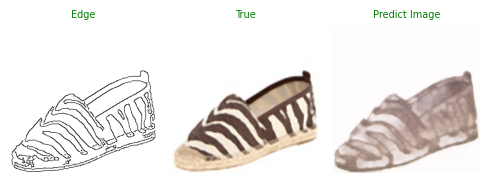

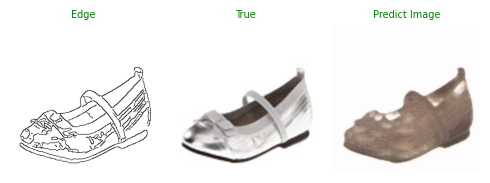

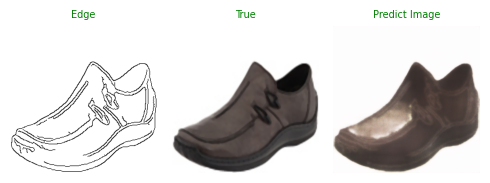

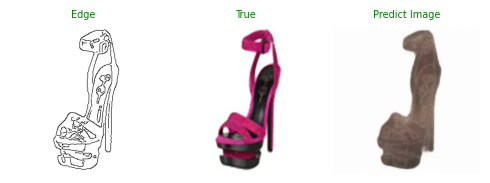

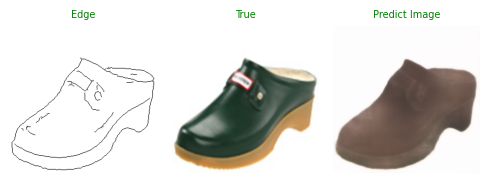

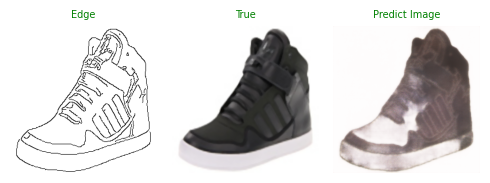

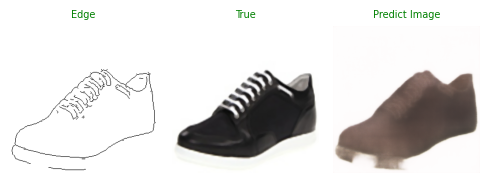

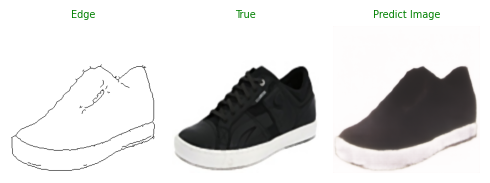

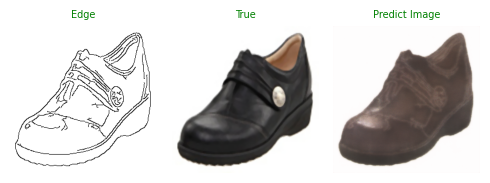

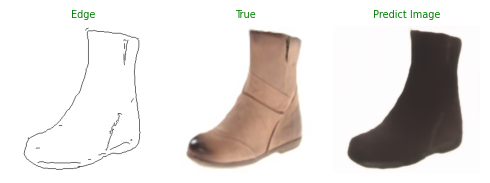

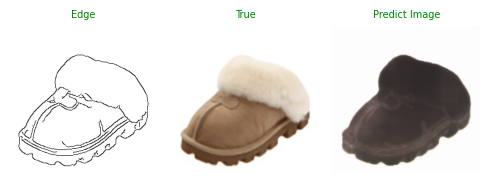

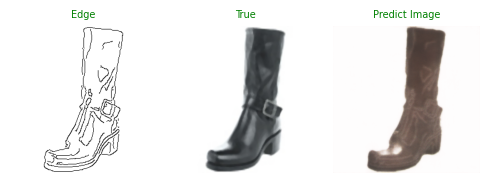

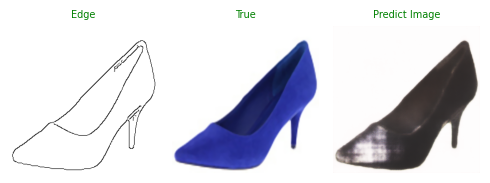

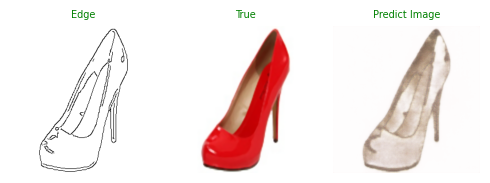

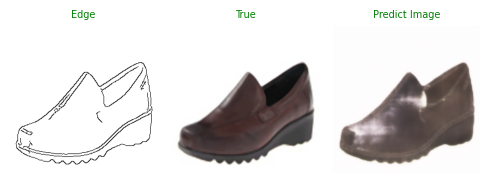

In [153]:
TEST_DIR_PATH = os.path.join(BASE_DIR,'test')
os.makedirs(TEST_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y  = val_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    if i == 15:
        break
    
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i][:,:,0] * 0.5 + 0.5, cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i] * 0.5 + 0.5)
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i] * 0.5 + 0.5)
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TEST_DIR_PATH, f'test sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step 


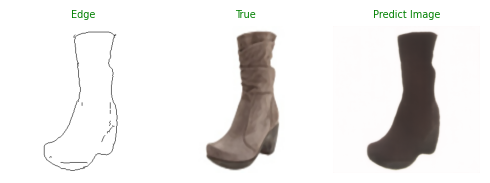

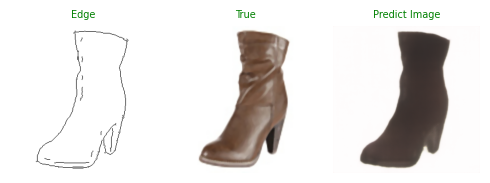

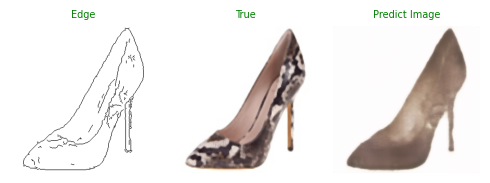

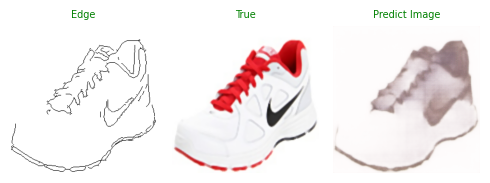

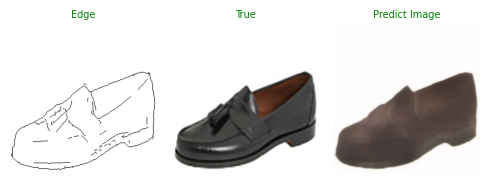

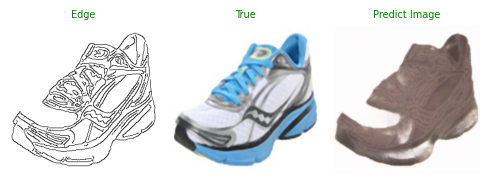

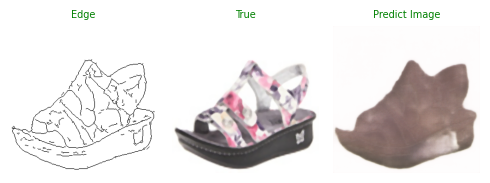

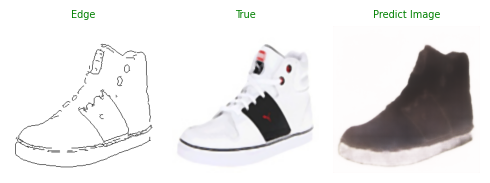

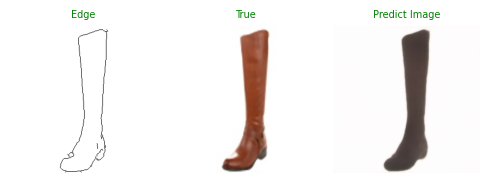

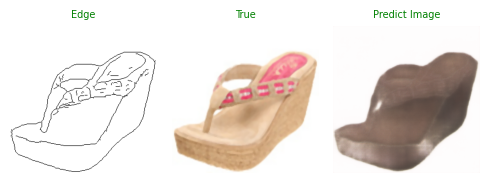

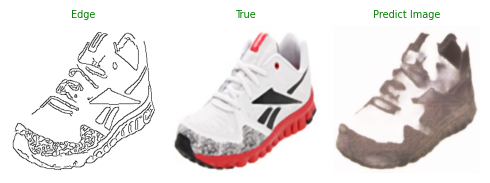

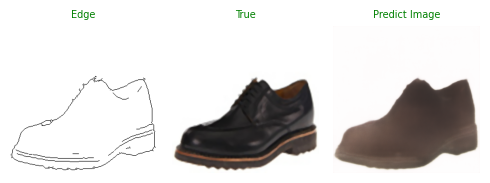

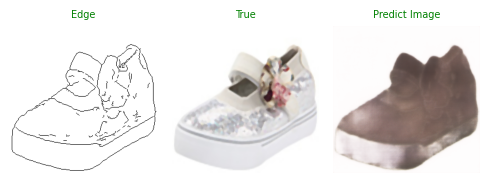

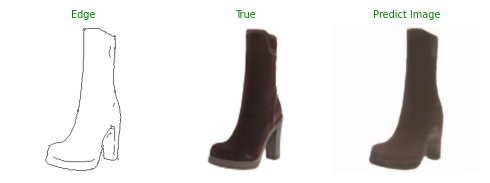

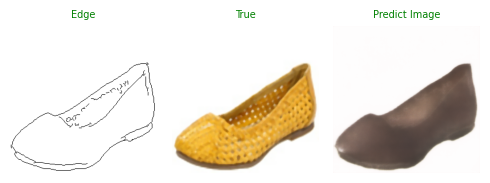

In [154]:
TRAIN_DIR_PATH = os.path.join(BASE_DIR,'train')
os.makedirs(TRAIN_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y = train_pure_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    if i == 15:
        break
        
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i][:,:,0] * 0.5 + 0.5, cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i] * 0.5 + 0.5, cmap='gray')
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i] * 0.5 + 0.5, cmap='gray')
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TRAIN_DIR_PATH, f'train sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff
    plt.show()

# Depolyment